In [10]:
pip install music21

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import os

import music21
from music21 import *

import IPython
from IPython.display import Image, Audio, SVG, display

**Prepare dataset**

In [12]:
filepath = "Beethoven/"
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".midi"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [13]:
# convert all chords and notes to a list of notes as strings

def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.extend(element.pitchNames)

    return notes

Corpus = extract_notes(all_midis)
print("Total notes in all the midis in the dataset:", len(Corpus))

Total notes in all the midis in the dataset: 1005283


In [14]:
set(Corpus)

{'A',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'B',
 'B-',
 'B-1',
 'B-2',
 'B-3',
 'B-4',
 'B-5',
 'B-6',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'C',
 'C#',
 'C#2',
 'C#3',
 'C#4',
 'C#5',
 'C#6',
 'C#7',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'D',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'E',
 'E-',
 'E-1',
 'E-2',
 'E-3',
 'E-4',
 'E-5',
 'E-6',
 'E-7',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'F',
 'F#',
 'F#1',
 'F#2',
 'F#3',
 'F#4',
 'F#5',
 'F#6',
 'F#7',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'G',
 'G#',
 'G#1',
 'G#2',
 'G#3',
 'G#4',
 'G#5',
 'G#6',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5',
 'G6'}

#### Prepare for Dataset

In [15]:
all_notes       = list(set(Corpus))
n_notes         = len(all_notes)
file            = Corpus
file_len        = len(Corpus)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_notes))
print('Number of all possible characters: {}'.format(n_notes))

Length of file: 1005283
All possible characters: ['F#4', 'G#', 'C5', 'G2', 'C6', 'F2', 'F5', 'E-1', 'C#2', 'F#1', 'G1', 'E-5', 'D5', 'E5', 'C#4', 'F#5', 'F1', 'C3', 'G6', 'B-', 'G5', 'B-4', 'C#3', 'B4', 'C7', 'B', 'E2', 'E1', 'B-5', 'F#7', 'C#', 'G#4', 'A1', 'F6', 'D2', 'G4', 'B1', 'C#7', 'A5', 'B3', 'D6', 'G#6', 'C', 'B6', 'B-2', 'E-', 'E6', 'G#1', 'F4', 'B-3', 'G#3', 'E7', 'C4', 'F3', 'E3', 'E4', 'C1', 'E-4', 'D7', 'B2', 'B5', 'A2', 'E-2', 'C2', 'E-6', 'D3', 'D1', 'F#2', 'F', 'F#6', 'G#2', 'A', 'C#5', 'D4', 'A3', 'B-6', 'G', 'A6', 'G3', 'D', 'F7', 'C#6', 'F#', 'E-7', 'G#5', 'E', 'B-1', 'A4', 'F#3', 'E-3']
Number of all possible characters: 90


In [16]:
# Get a random sequence of the dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_notes) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, note in enumerate(seq):
        for i, n in enumerate(all_notes):
            if n in note:
                tensor[t][0][i] = 1
        
        #index = all_notes.index(note)
        #tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, note in enumerate(seq):
        for i, n in enumerate(all_notes):
            if n in note:
                tensor[t] = i
        
        #tensor[t] = all_notes.index(note)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    #print(seq)
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    #print(input)
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [17]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [18]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_notes   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_notes   # Output size: Number of unique chars.
        
        self.rnn_cell = nn.RNNCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.rnn_cell(input, hidden)
        output = self.linear(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn_cell): RNNCell(90, 100)
  (linear): Linear(in_features=100, out_features=90, bias=True)
)

#### Training Step and Evaluation Step

In [19]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [20]:
# Evaluation step function.
def eval_step(net, init_seq='F', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq + " "

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_note  = all_notes[predicted_index]
        predicted_seq += predicted_note + " "
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_note)[0].to(device)

    return predicted_seq

#### Training Procedure

In [21]:
# Number of iterations.
iters       = 7000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/7000 loss:2.4504754543304443
generated sequence: F C A A3 A D B C E B D A C A A F F# A4 E F A E G D F D G F B F A D F# C C D B D E B F A3 C B3 E B B E E B2 F G E E F A G F B A4 F D F D E F#3 F#3 C C G A F F F G D F C A G C G G G C4 C A G F B B F D A3 G F# C D F G F 

iter:199/7000 loss:2.3778269290924072
generated sequence: F F C B E F A E G E E G F F G G G G C B F G B F E B2 C C G F F C F F F C F G C#6 B3 G F# E F E C C F# C F#3 B F F F C F C F F G D A A A E D F G G C C E B-5 F# C C F# G D C C E G F C C C B A C B3 E B5 F D G B E C F B 

iter:299/7000 loss:2.3506853580474854
generated sequence: F F D A A B G B C4 F C G C B F G F G C F F G B C B B-2 B B B A C G C C F G#5 C B C B C G G E E F D F B C D B A G F B F B E A F B5 G G C B F F C B C B C E B E C F G F E F C G#5 E E A C B C C C F B G C C E F# D A4 

iter:399/7000 loss:2.341447591781616
generated sequence: F F# D B G B D D G E F F# G F# F G B F G A3 G G D B A E G E F F E G B E G B-5 C C F# D B C F F E C2 C F F# A4 E F# C B3

#### Training Loss Curve

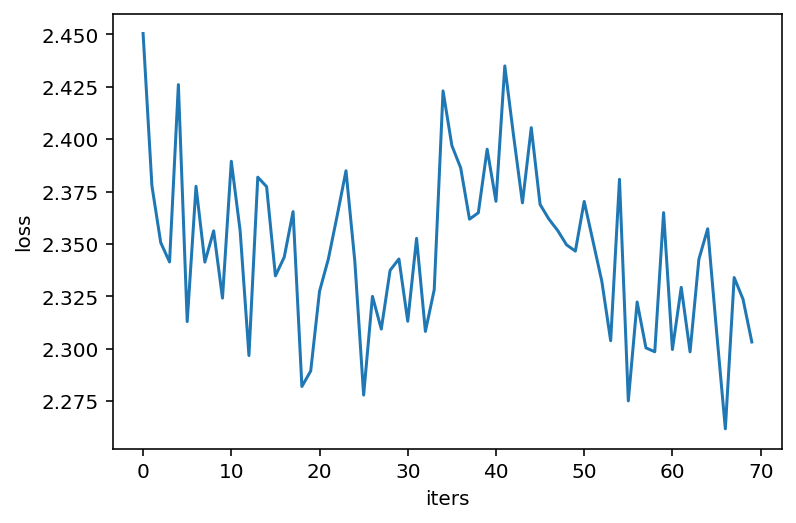

In [22]:
np_all_losses = [loss.item() for loss in all_losses]
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np_all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [23]:
generated_seq = eval_step(net, predicted_len=600)
print(generated_seq)

F G A A A B F B A E G E C G B B B E A G E B F# F# C B1 C E C G E E E A C G B B D E F G G D B E G D G E D A F A A A A E A A C A B A G B D D C C E F B1 B-3 B B E G A A C A D D A G D B D F# C G G G G G G A G G B C A F# E G B A F C C F G F C E A F B2 B A D B A E B F A B A D B C G F C D F A C#5 B A E D A E G3 E A A A E E C#5 G G G D B B D B C G G A G D B C C C4 C G G G G D F A C C A G A E A E F A A A3 A F B A B F G B G F# G G D A G D F G D A B2 G C D B G G C D B5 A D A A B G E A C G B B C F C D B A D B F# E G E A F A A C F E E F# A D D G C G G G D E B B G F E G G G E G G G G G F B2 E G D B A D G C C D D A C4 E D C A E B G D F G E E C A E F# B A A A F# F B F F B B B G G F G C E E B B D G A F C G G G E G E-3 G G G E C D C4 D B D G B B G B D G A D F G F F C E C B E C E D B D D B B D E C E B A G E G G E G C F A G D C E C D F G G C G E G G G A F F F B G A F F G A C A E F# A4 A A A G A A A F D D B G B D C E G G C G A D G G C B B G C A D D D F C C C F#3 A E A C E A A D A A A C A A G D B D A F B B 

**Play the Generated Sequence**

In [24]:
def sequence_notes(Snippet):
    seq = list(Snippet.split(" "))[:-1]
    Melody = []
    offset = 0 # determines position of notes
    for i in seq:
        curr = note.Note(i)
        curr.offset = offset
        Melody.append(curr)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody = sequence_notes(generated_seq)
print(Melody)

<music21.stream.Stream 0x7f4b9af0b6a0>


In [25]:
Melody.write('midi', 'generated_melody.midi')
Melody.show('midi')